<a href="https://colab.research.google.com/github/lahoffman/AI4InSync/blob/main/nn_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0 Setup



## 0.1 Set up your Google Colab Notebook to run this tutorial.



In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


You will need to complete the following steps before you run this tutorial:

1. Save a copy of this notebook in your drive
  - File --> 'Save a copy in Drive'
2. Download the data from zenodo:
  - Go to the github link for this tutorial (https://github.com/lahoffman/AI4InSync).
  - Navigate to the 'README' file
  - Click the link for the zenodo data (https://doi.org/10.5281/zenodo.15478201)
  -Download the data to your personal computer (<50MB)
3. Make a 'data' folder in your 'Colab Notebooks' folder in your google drive
  - On the left-hand toolbar for this page (i.e. your copy of the 'nn_reconstruction.ipynb' notebook), click on the 'folder' icon.
  - Click on the small dropdown arrow next to 'drive' --> 'MyDrive' --> 'Colab Notebooks'.
  - Make a 'data' folder in your 'Colab Notebooks' folder
    - click the three dots to the right of "Colab Notebooks"
    - click 'New folder'; name the folder 'data'
4. Upload the dataset to your 'data' folder
  - click the three dots to the right of the 'data' folder
  - click 'upload'
  - find the 'RECONSTRUCTION_DATA.nc' file you had downloaded to your comptuer
  - click 'upload'.
5. You are ready to run this notebook!

## 0.2 Set up Coding Environments

In [49]:
#system
import sys
import numpy as np
import seaborn as sb
import xarray as xr
import h5py
!pip install netCDF4
import netCDF4 as nc
from netCDF4 import Dataset
from scipy import stats, odr
from scipy.io import netcdf, loadmat
from scipy.stats import norm
from datetime import datetime, timedelta
import cftime

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
!pip install cmocean
import cmocean


#machine learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import backend as K
import keras.utils
import sklearn
from sklearn.model_selection import train_test_split


In [50]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
numpy version = 2.0.2
tensorflow version = 2.18.0


# 1. Data Preparation

We take outputs from three CMIP6 models, co-located to match the times and locations of observations made by the Ice Tethered Profiler dataset in the Arctic. We then prepare this data to be used in a neural network.

##1.1 About the Data

In this module we will train a machine learning model to learn daily Arctic sea ice velocity from information about wind velocity and ice concentration. The ML model will be trained using outputs from several CMIP6 models subsampled at locations of Ice Tethered Profiler (ITP) observations.


###1.1.1 Coupled Model Intercomparison Project phase 6 (CMIP6)

We use zonal and meridional sea ice velocity (siu, siv), wind velocity (uas, vas), and sea ice concentration (siconc) from the historical runs of the following CMIP6 models and ensemble members:

1.   CanESM5 [10]
2.   IPSL-CM6A-LR [31]
3.   MIROC6 [10]

The data from CMIP6 can be found on the Earth System Grid Federation (ESFF) nodes: https://esgf-node.llnl.gov/projects/cmip6/

Eyring, V., Bony, S., Meehl, G., Senior, C., Stevens, B., Ronald, S., & Taylor, K. (2015, 12). Overview of the coupled model intercomparison project phase 6 (cmip6) experimental design and organisation. Geoscientific Model Development Discussions, 8 , 10539-10583. doi: 10.5194/gmdd-8-10539-2015

###1.1.2 Ice-Tethered Profilers: Ice Veolcity Vectors

We will be using the Ice-Tethered Profiler (ITP) dataset from WHOI. While the ITPs measure many quantities, we will be using ice velocity derived from the measured geographic locations of the ITPs.

The following images, captions, and data were collected and made available by the Ice-Tethered Profiler Program (Toole et al., 2011; Krishfield et al., 2008) based at the Woods Hole Oceanographic Institution (https://www.whoi.edu/itp).


<img src='https://www2.whoi.edu/site/itp/wp-content/uploads/sites/92/2019/08/itp_mooring.jpg' width = '200' height = '300'>

*The ITP system consists of a small surface capsule that sits atop an ice flow and supports a plastic-jacketed wire rope tether that extends through the ice and down into the ocean, ending with a weight (intended to keep the wire vertical). A cylindrical underwater instrument (in shape and size much like an Argo float) mounts on this tether and cycles vertically along it, carrying oceanographic sensors through the water column.  Water property data are telemetered from the ITP to shore in near-real time.*

<img src = 'https://www.whoi.edu/itp/images/itpall.jpg?_gl=1*50odkx*_ga*NjU0NzIwMTI4LjE2NzgxMjI5NDY.*_ga_HLKFZX9JZK*MTY3ODEyMjk0Ni4xLjEuMTY3ODEyMzM4My4wLjAuMA..' width = '400' height = '300'>

*Latest locations of all active ITPs. Systems that are presently providing location and profile data are in yellow, those that are providing locations only (profiler status uncertain) are in cyan, and those that have not transmitted data for over one month are plotted in gray. Also shown are annual ice drift vectors from IABP on IBCAO bathymetry.*

TOOLE, JOHN M., et al. “THE ICE-TETHERED PROFILER: ARGO OF THE ARCTIC.” Oceanography, vol. 24, no. 3, 2011, pp. 126–35. JSTOR, http://www.jstor.org/stable/24861307.

Krishfield, R., Toole, J., Proshutinsky, A., & Timmermans, M. (2008). Automated Ice-Tethered Profilers for Seawater Observations under Pack Ice in All Seasons, Journal of Atmospheric and Oceanic Technology, 25(11), 2091-2105.

## 1.2 Data Download

In [51]:
#allow access to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
#import dataset
loadpath = '/content/drive/MyDrive/Colab Notebooks/data/RECONSTRUCTION_MASK.nc'
dataset = nc.Dataset(loadpath,'r')

In [53]:
#variables
lat = np.array(dataset.variables['lat']) #latitude
lon = np.array(dataset.variables['lon']) #longitude
date = np.array(dataset.variables['date']) #date
sic = np.array(dataset.variables['sic_CMIP6']) #siconc
uas = np.array(dataset.variables['uas_CMIP6']) #u-wind
vas = np.array(dataset.variables['vas_CMIP6']) #v-wind
siu = np.array(dataset.variables['siu_CMIP6']) #u-ice
siv = np.array(dataset.variables['siv_CMIP6']) #v-ice

#calculate speed
icespeed = np.sqrt(np.square(siu) + np.square(siv))
windspeed = np.sqrt(np.square(uas) + np.square(vas))

#calculate day of year
ref_date = datetime(1850, 1, 1)
doy = np.array([(ref_date + timedelta(days=int(d))).timetuple().tm_yday for d in date])


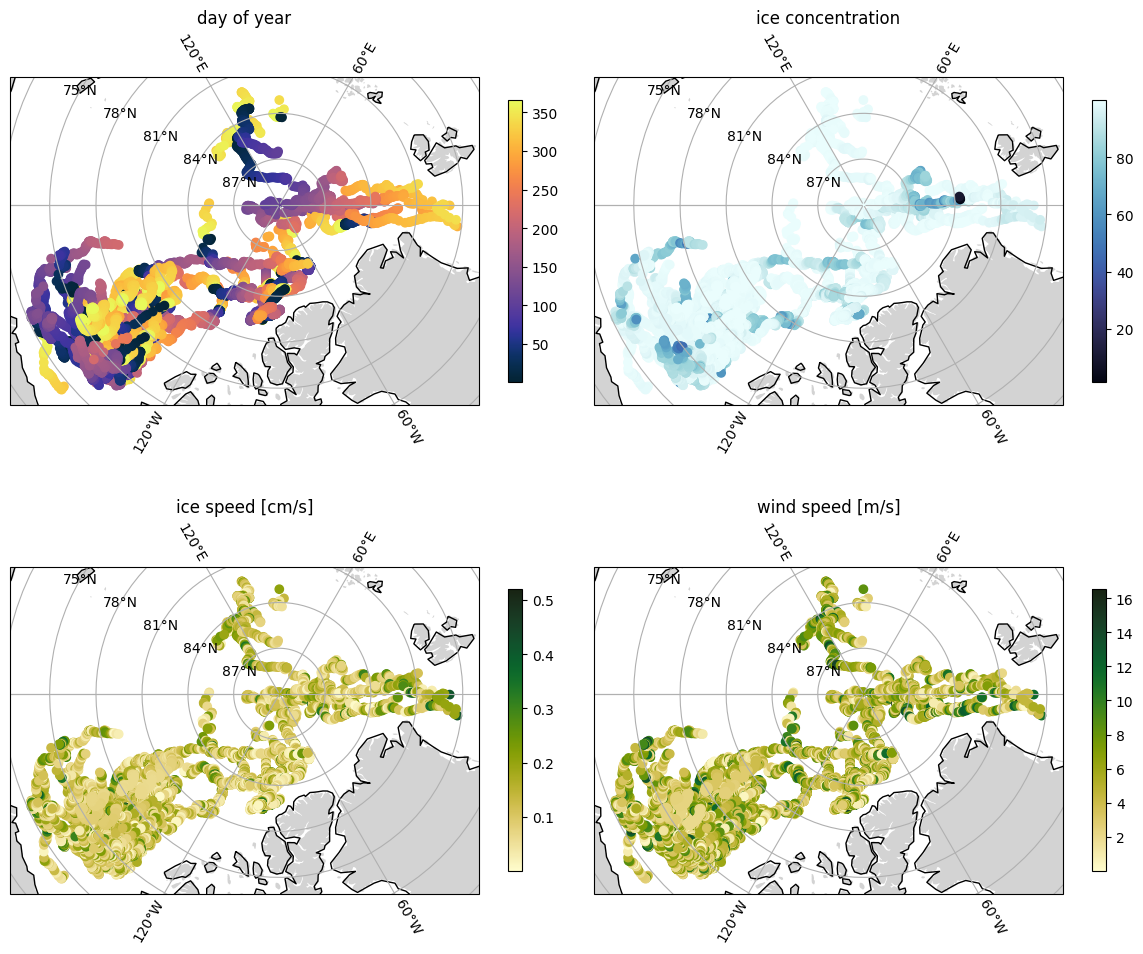

In [54]:
#(a) maps
#here we look at maps showing properties of interest at locations of the ITPs.
ensemble_no = 31 #choose 0-31

# Set up the figure
fig = plt.figure(figsize=(12, 10))

# Common projection: North Polar Stereographic
proj = ccrs.NorthPolarStereo(central_longitude=270)

def setup_ax(ax, title):
    ax.set_title(title)
    ax.coastlines(resolution='110m')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    #ax.add_feature(cfeature.OCEAN, facecolor='aqua')
    ax.gridlines(draw_labels=True)

# Day of year
ax = fig.add_subplot(221, projection=proj)
setup_ax(ax, 'day of year')
sc = ax.scatter(lon, lat, c=doy, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6)

# Ice concentration
ax = fig.add_subplot(222, projection=proj)
setup_ax(ax, 'ice concentration')
sc = ax.scatter(lon, lat, c=sic[ensemble_no,:], cmap=cmocean.cm.ice, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6)

# Ice speed
ax = fig.add_subplot(223, projection=proj)
setup_ax(ax, 'ice speed [cm/s]')
sc = ax.scatter(lon, lat, c=icespeed[ensemble_no,:], cmap=cmocean.cm.speed, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6)

# Wind speed
ax = fig.add_subplot(224, projection=proj)
setup_ax(ax, 'wind speed [m/s]')
sc = ax.scatter(lon, lat, c=windspeed[ensemble_no,:], cmap=cmocean.cm.speed, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6)

plt.tight_layout()
plt.show()

Text(0, 0.5, 'ice concentration')

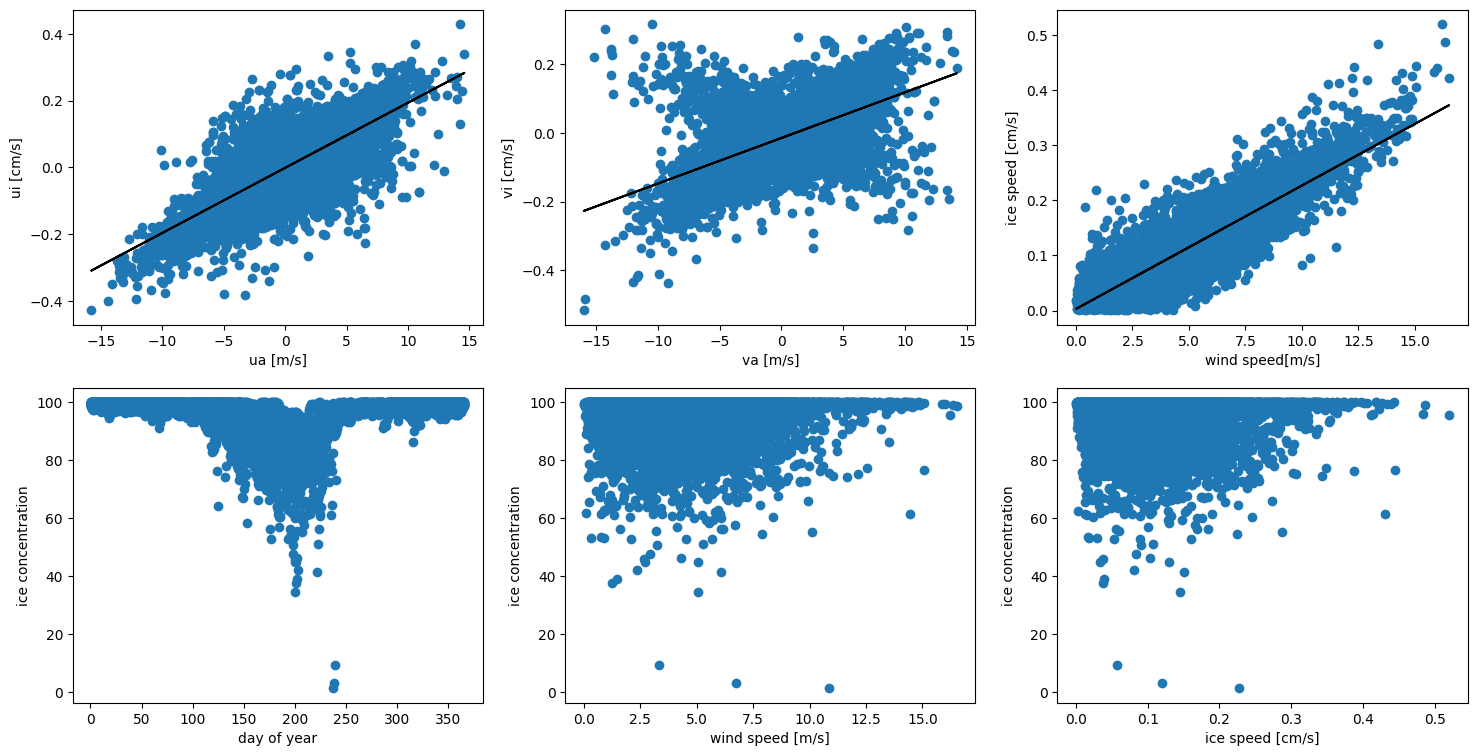

In [55]:
#(b) scatter: compare variables
#here we look at plots comparing some of the variables to get an idea of the relationships between them
ua = uas[ensemble_no,:]
va = vas[ensemble_no,:]
ui = siu[ensemble_no,:]
vi = siv[ensemble_no,:]
ci = sic[ensemble_no,:]
wspeed = windspeed[ensemble_no,:]
ispeed = icespeed[ensemble_no,:]

fig, axs = plt.subplots(2, 3,figsize=(18,9))
axs[0,0].scatter(ua,ui)
axs[0,0].set_xlabel('ua [m/s]')
axs[0,0].set_ylabel('ui [cm/s]')
x, y = np.squeeze(ua), np.squeeze(ui)
mask = ~np.isnan(x) & ~np.isnan(y)
x_clean, y_clean = x[mask], y[mask]
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(x_clean),np.squeeze(y_clean))
axs[0,0].plot(ua,intercept+ua*slope,'-',color = 'black', label = 'LSQ: x vs y')

axs[0,1].scatter(va,vi)
axs[0,1].set_xlabel('va [m/s]')
axs[0,1].set_ylabel('vi [cm/s]')
x, y = np.squeeze(va), np.squeeze(vi)
mask = ~np.isnan(x) & ~np.isnan(y)
x_clean, y_clean = x[mask], y[mask]
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(x_clean),np.squeeze(y_clean))
axs[0,1].plot(va,intercept+va*slope,'-',color = 'black', label = 'LSQ: x vs y')

axs[0,2].scatter(wspeed,ispeed)
axs[0,2].set_xlabel('wind speed[m/s]')
axs[0,2].set_ylabel('ice speed [cm/s]')
x, y = np.squeeze(wspeed), np.squeeze(ispeed)
mask = ~np.isnan(x) & ~np.isnan(y)
x_clean, y_clean = x[mask], y[mask]
slope, intercept, r_value, p_value, std_err = stats.linregress(np.squeeze(x_clean),np.squeeze(y_clean))
axs[0,2].plot(wspeed,intercept+wspeed*slope,'-',color = 'black', label = 'LSQ: x vs y')

axs[1,0].scatter(doy,ci)
axs[1,0].set_xlabel('day of year')
axs[1,0].set_ylabel('ice concentration')

axs[1,1].scatter(wspeed,ci)
axs[1,1].set_xlabel('wind speed [m/s]')
axs[1,1].set_ylabel('ice concentration')

axs[1,2].scatter(ispeed,ci)
axs[1,2].set_xlabel('ice speed [cm/s]')
axs[1,2].set_ylabel('ice concentration')

## 1.3 Processing Data for ML

### 1.3.1 Partitioning Data in Training, Validation, and Test Datasets

Data are split into train, validate, and test sets before entered into a ML model, typically with an 80% - 10% - 10% split.

***Train:***  Training data is used to fit the model.

***Validate:*** The validation dataset is used to evaluate the model fit during training and update the model hyperparameters.

***Test:*** The test dataset is not seen by the model during training and use used to provide an unbias evaluation of the final model fit.


In [56]:
emf = 26
em0 = 31
em02 = 21

sic_tr = sic[:-em0,:]
sic_va = sic[-em0:-emf,:]
sic_te = sic[-emf:-em02,:]

uas_tr = uas[:-em0,:]
uas_va = uas[-em0:-emf,:]
uas_te = uas[-emf:-em02,:]

vas_tr = vas[:-em0,:]
vas_va = vas[-em0:-emf,:]
vas_te = vas[-emf:-em02,:]

siu_tr = siu[:-em0,:]
siu_va = siu[-em0:-emf,:]
siu_te = siu[-emf:-em02,:]

siv_tr = siv[:-em0,:]
siv_va = siv[-em0:-emf,:]
siv_te = siv[-emf:-em02,:]

doy_en = np.tile(doy,(51,1))
doy_tr = doy_en[:-em0,:]
doy_va = doy_en[-em0:-emf,:]
doy_te = doy_en[-emf:-em02,:]

lat_en = np.tile(lat,(51,1))
lat_tr = lat_en[:-em0,:]
lat_va = lat_en[-em0:-emf,:]
lat_te = lat_en[-emf:-em02,:]

lon_en = np.tile(lon,(51,1))
lon_tr = lon_en[:-em0,:]
lon_va = lon_en[-em0:-emf,:]
lon_te = lon_en[-emf:-em02,:]

train = np.concatenate((uas_tr[np.newaxis,:,:],vas_tr[np.newaxis,:,:],sic_tr[np.newaxis,:,:],doy_tr[np.newaxis,:,:],lat_tr[np.newaxis,:,:],lon_tr[np.newaxis,:,:],siu_tr[np.newaxis,:,:],siv_tr[np.newaxis,:,:]),axis=0)
val = np.concatenate((uas_te[np.newaxis,:,:],vas_te[np.newaxis,:,:],sic_te[np.newaxis,:,:],doy_te[np.newaxis,:,:],lat_te[np.newaxis,:,:],lon_te[np.newaxis,:,:],siu_te[np.newaxis,:,:],siv_te[np.newaxis,:,:]),axis=0)
test = np.concatenate((uas_va[np.newaxis,:,:],vas_va[np.newaxis,:,:],sic_va[np.newaxis,:,:],doy_va[np.newaxis,:,:],lat_va[np.newaxis,:,:],lon_va[np.newaxis,:,:],siu_va[np.newaxis,:,:],siv_va[np.newaxis,:,:]),axis=0)

print(np.isnan(train).sum())
print(np.isnan(val).sum())
print(np.isnan(test).sum())

nc_tr = train.shape[1]
nt_tr = train.shape[2]

nc_te = test.shape[1]
nt_te = test.shape[2]

nc_va = val.shape[1]
nt_va = val.shape[2]


print(nc_tr)
print(nc_va)
print(nc_te)




0
0
0
20
5
5


### 1.3.1 Feature Scaling

#### Why do we apply Feature Scaling?
Features (or variables) that are input to a ML model may have vastly different ranges, which might cause a ML model to put more weights on variables with a larger range. Feature Scaling (either standardization or normalization) makes it so features are on similar scales.

***Standardization:*** Here, sea ice and atmospheric data is standardized to zero mean and one standard deviation (i.e. subtract mean and divide by standard deviation). Day-of-year, latitude, and longitude are standardized based on their maximum value.

It is best practice to standardize data to the training dataset, as to prevent data leakage during ML training and testing. Data leakage happens when information outside of the training data is used to create the model, which can lead to inflated performance and poor generalization.

In [57]:
prop_train = []
prop_val = []
prop_test = []

miui = []
stdi = []

for i in range(8):
    prop_tr = train[i,:,:]
    prop_va = val[i,:,:]
    prop_te = test[i,:,:]

    miu = np.nanmean(prop_tr,axis=(0,1))
    stdev = np.nanstd(prop_tr,axis=(0,1))

    if i == 3:
        tr_standardized = prop_tr/365
        te_standardized = prop_te/365
        va_standardized = prop_va/365
    elif i == 4:
        tr_standardized = prop_tr/90
        te_standardized = prop_te/90
        va_standardized = prop_va/90
    elif i == 5:
        tr_standardized = prop_tr/180
        te_standardized = prop_te/180
        va_standardized = prop_va/180
    else:
        tr_standardized = (prop_tr-miu)/stdev
        te_standardized = (prop_te-miu)/stdev
        va_standardized = (prop_va-miu)/stdev

    prop_train.append(tr_standardized)
    prop_val.append(va_standardized)
    prop_test.append(te_standardized)

    miui.append(miu)
    stdi.append(stdev)

train_std = np.array(prop_train)
validate_std = np.array(prop_val)
test_std = np.array(prop_test)

miu_tr = np.array(miui)
std_tr = np.array(stdi)

print(miu_tr.shape)

(8,)


###1.3.2 ALL ITP Locations

In [58]:
nc_tr = train_std.shape[1]
nt_tr = train_std.shape[2]

nc_te = test_std.shape[1]
nt_te = test_std.shape[2]

nc_va = validate_std.shape[1]
nt_va = validate_std.shape[2]


x_tr = np.reshape(train_std[:6,:,:],(6,nc_tr*nt_tr)).T
y_tr = np.reshape(train_std[6:,:,:],(2,nc_tr*nt_tr)).T

x_va = np.reshape(validate_std[:6,:,:],(6,nc_te*nt_te)).T
y_va = np.reshape(validate_std[6:,:,:],(2,nc_te*nt_te)).T

x_te = np.reshape(test_std[:6,:,:],(6,nc_te*nt_te)).T
y_te = np.reshape(test_std[6:,:,:],(2,nc_te*nt_te)).T

print(np.isnan(x_tr).sum())
print(np.isnan(y_tr).sum())
print(np.isnan(x_va).sum())
print(np.isnan(y_va).sum())
print(np.isnan(x_te).sum())
print(np.isnan(y_te).sum())

0
0
0
0
0
0


# 2. Neural Network

We will train a simple neural network to predict zonal and meridional sea-ice velocity components from various inputs (zonal and meridional wind velocity, sea-ice concentration, latitude, longitude, day of year).

## 2.1 Define Custom Metrics and Loss Functions

What is a loss function?

The cost / loss function evaluates the difference between the model prediction and the true data during training.


In [59]:
#define NRMSE function
def norm_root_mean_squared_error(y_true,y_pred):
    return  (K.sqrt(K.mean(K.square(y_pred - y_true))))/((K.std(y_true)))

#define pearson correlation
def corr(y_true, y_pred):
    return (K.sum((y_true-K.mean(y_true))*(y_pred-K.mean(y_pred))))/((K.sqrt(K.sum(K.square(y_true-K.mean(y_true)))))*(K.sqrt(K.sum(K.square(y_pred-K.mean(y_pred))))))

## 2.2 Define Model Hyperparameters

In [60]:
# Here are some model hyperparameters we can edit

# LOSS FUNCTION
LOSS = norm_root_mean_squared_error # Loss Function used
METRIC = corr # Metric for assessing model skill

# MODEL TRAINING
N_UNITS = 10 # number of nodes in layer
NUM_EPOCHS = 20 # Max number of times all of the data will be seen iteratively in training
BATCH_SIZE = 100 # Number of samples per epoch
LEARNING_RATE = .01 # Learning rate (think step size)
DROP = 0.2 # dropout rate
ACTIVATION_FUNCTION = 'relu' #activation function
OPTIMIZER = 'adam' #gradient descent algorithm
RL2 = 0.001

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#OTHER LOSS FUNCTIONS
#LOSS = tf.keras.losses.MeanSquaredError
#LOSS = tf.keras.losses.RootMeanSquaredError
#LOSS = 'tf.keras.losses.MeanAbsoluteError
#LOSS = tf.keras.losses.Huber

#OTHER ACTIVATION FUNCTIONS
#ACTIVATION_FUNCTION = 'leaky_relu'
#ACTIVATION_FUNCTION = 'elu'



## 2.3 Building a Neural Network: Deep NN w/ hidden layers

###2.3.1 Compile and train the model

Epoch 1/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - corr: 0.5795 - loss: 0.7894 - val_corr: 0.7453 - val_loss: 0.6146
Epoch 2/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - corr: 0.8092 - loss: 0.6095 - val_corr: 0.8438 - val_loss: 0.5326
Epoch 3/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - corr: 0.8650 - loss: 0.5340 - val_corr: 0.8758 - val_loss: 0.4961
Epoch 4/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - corr: 0.8828 - loss: 0.5060 - val_corr: 0.8886 - val_loss: 0.4807
Epoch 5/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - corr: 0.8934 - loss: 0.4874 - val_corr: 0.9013 - val_loss: 0.4635
Epoch 6/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - corr: 0.9022 - loss: 0.4707 - val_corr: 0.9070 - val_loss: 0.4530
Epoch 7/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - corr: 0.9074 - loss: 0.4601 - val_corr: 0.9111 - val_loss: 0.4491
Epoch 8/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - corr: 0.9114 - loss: 0.4517 - val_corr: 0.9159 - val_loss: 0.4412
Epoch 9/20
2249/224

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608 (2.38 KB)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 406 (1.59 KB)

None


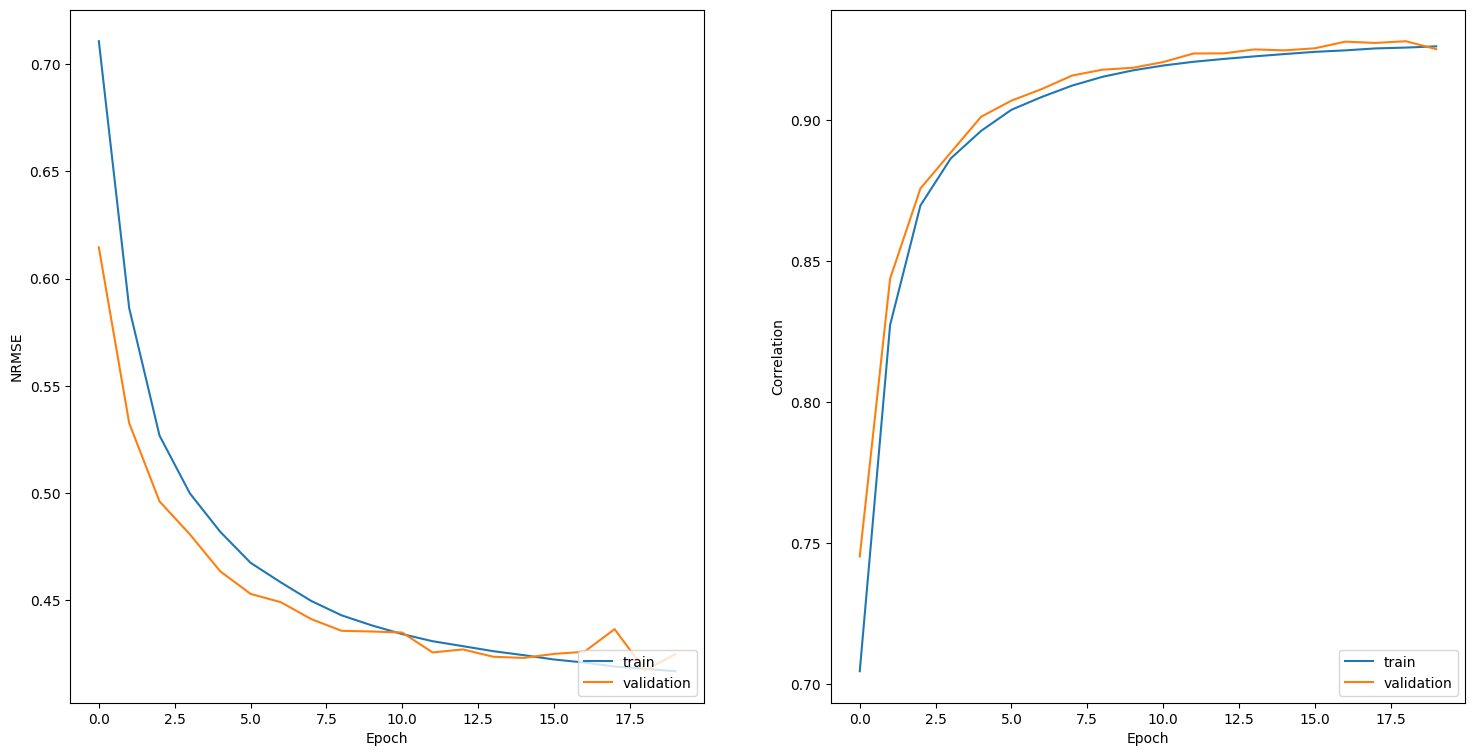

In [61]:
# Example: build a fully-connected network

# In Keras a NN model is built in layers
# Most common type is sequential layers - one layer after the other with
# connections only between neighboring layers.

[nd,nch] = y_tr.shape #shape of training data

# define the model
model = tf.keras.Sequential()
model.add(layers.Dense(N_UNITS,activation=ACTIVATION_FUNCTION,kernel_regularizer=tf.keras.regularizers.l2(RL2)))
model.add(layers.Dense(N_UNITS,activation=ACTIVATION_FUNCTION,kernel_regularizer=tf.keras.regularizers.l2(RL2)))
model.add(layers.Dense(nch,activation=None))

#compile and train model
model.compile(optimizer=OPTIMIZER,loss=LOSS ,metrics=[METRIC])

# train the model
history = model.fit(x_tr,y_tr,epochs=NUM_EPOCHS,batch_size=BATCH_SIZE,shuffle=True,validation_data=(x_va,y_va))
print(history)
print(model.summary())

#evaluate model: plot the loss during training
plot1 = plt.figure(1,figsize=(18,9))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['corr'],label='train')
plt.plot(history.history['val_corr'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.legend(loc='lower right')
plt.show()


###2.3.2. Evaluate and Visualize Model Predictions

Made predictions with the model using the test dataset

In [62]:
# make predictions with your model using the test dataset
y_true = y_te
y_pred = model.predict(x_te)

1757/1757 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Evaluate model performance (correlation and skill)

In [63]:
skill = 1 - (np.sqrt(np.mean(np.square(y_pred - y_true))))/((np.std(y_true)))
corre = (np.sum((y_true-np.mean(y_true))*(y_pred-np.mean(y_pred))))/((np.sqrt(np.sum(np.square(y_true-np.mean(y_true)))))*(np.sqrt(np.sum(np.square(y_pred-np.mean(y_pred))))))

print('skill:',skill)
print('correlation:',corre)

skill: 0.6148601885083361
correlation: 0.9237933225950666


Plot model evaluations: (a) scatter of true vs. predicted

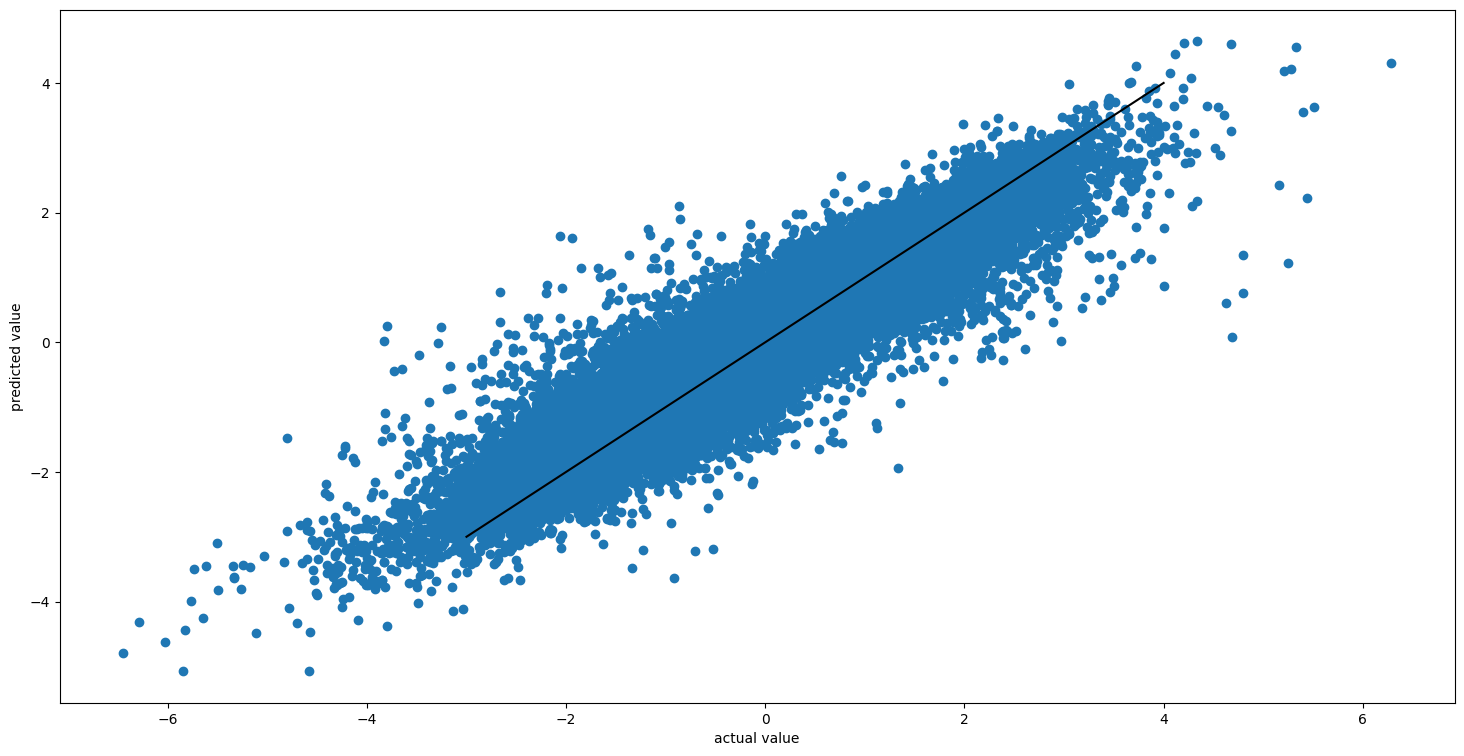

(56210,)
(56210, 2)
(5, 11242)


In [64]:
#plot evaluations of predictions made on test data
import matplotlib.path as mpath

# (a) scatter of true vs. predicted
plt.figure(figsize=(18,9))
plt.scatter(y_true,y_pred)
plt.plot([-3,4],[-3,4],color='black')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

# (b) map of true-predicted for ui and vi

# RMS difference betwen "actual" and "predicted" values of ui and vi
vrms = np.sqrt(np.square(y_true[:,1]-y_pred[:,1]))
urms = np.sqrt(np.square(y_true[:,0]-y_pred[:,0]))

#difference
vdiff = y_true[:,1]-y_pred[:,1]
udiff = y_true[:,0]-y_pred[:,0]

print(vdiff.shape)
print(y_true.shape)
print(lat_te.shape)



Plot model evaluations: (b) map of true-predicted

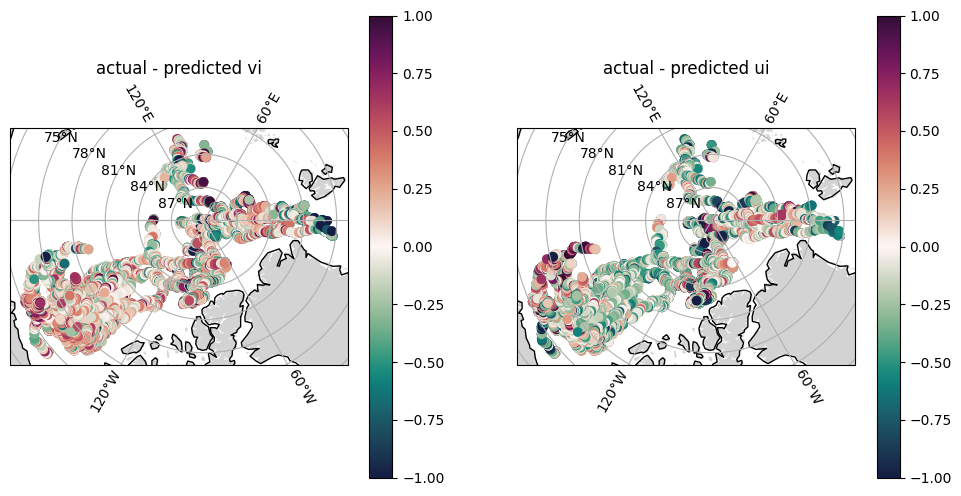

In [65]:
# Set up the figure
fig = plt.figure(figsize=(12, 10))

# Common projection: North Polar Stereographic
proj = ccrs.NorthPolarStereo(central_longitude=270)

# Data should be in lat/lon
# Example placeholder data:
# lonitp, latitp = np.meshgrid(np.linspace(-180, 180, 100), np.linspace(60, 90, 50))
# doy, ci, icespeed, windspeed = np.random.rand(4, *lonitp.shape)

def setup_ax(ax, title):
    ax.set_title(title)
    ax.coastlines(resolution='110m')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    #ax.add_feature(cfeature.OCEAN, facecolor='aqua')
    ax.gridlines(draw_labels=True)

# Day of year
ax = fig.add_subplot(121, projection=proj)
setup_ax(ax, 'actual - predicted vi')
sc = ax.scatter(lon_te, lat_te, c=vdiff, cmap=cmocean.cm.curl, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6)
sc.set_clim([-1, 1])

# Ice concentration
ax = fig.add_subplot(122, projection=proj)
setup_ax(ax, 'actual - predicted ui')
sc = ax.scatter(lon_te, lat_te, c=udiff, cmap=cmocean.cm.curl, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.6)
sc.set_clim([-1, 1])


plt.show()

# 3. Global Reconstructions

We will use our trained neural network to predict maps of sea-ice velocity from IPSL-CM6A-LR output, then compare our NN predictions to the IPSL-CM6A-LR sea-ice velocity maps.

## 3.1 Data Download

Import the dataset for making global reconstructions of sea ice velocity. This includes maps of wind velocity, sea-ice velocity, and sea-ice concentration from five ensemble members from the IPSL-CM6A-LR simulation in CMIP6.


In [66]:
#import dataset
loadpath = '/content/drive/MyDrive/Colab Notebooks/data/RECONSTRUCTIONS_MAPS.nc'
dataset = nc.Dataset(loadpath,'r')

In [67]:
#variables
lat = np.array(dataset.variables['lat']) #latitude
lon = np.array(dataset.variables['lon']) #longitude
date = np.array(dataset.variables['date']) #date
sic = np.array(dataset.variables['sic_IPSL']) #siconc
uas = np.array(dataset.variables['uas_IPSL']) #u-wind
vas = np.array(dataset.variables['vas_IPSL']) #v-wind
siu = np.array(dataset.variables['siu_IPSL']) #u-ice
siv = np.array(dataset.variables['siv_IPSL']) #v-ice

nx = siu.shape[0]
ny = siu.shape[1]
nt = siu.shape[2]

#calculate speed
icespeed = np.sqrt(np.square(siu) + np.square(siv))
windspeed = np.sqrt(np.square(uas) + np.square(vas))

#calculate day of year
ref_date = datetime(1850, 1, 1)
datei = date[0,0,:]
doyi = np.array([(ref_date + timedelta(days=int(d))).timetuple().tm_yday for d in datei])
doy =  np.tile(doyi,(nx,ny,1))
print(doy.shape)


#set model fill value to NaN
#arr[arr < 1e19] = np.nan
sic[sic>1e19] = np.nan
siu[siu>1e19] = np.nan
siv[siv>1e19] = np.nan

(332, 362, 10)


<ipython-input-67-e2a901cf0253>:16: RuntimeWarning: overflow encountered in square
  icespeed = np.sqrt(np.square(siu) + np.square(siv))


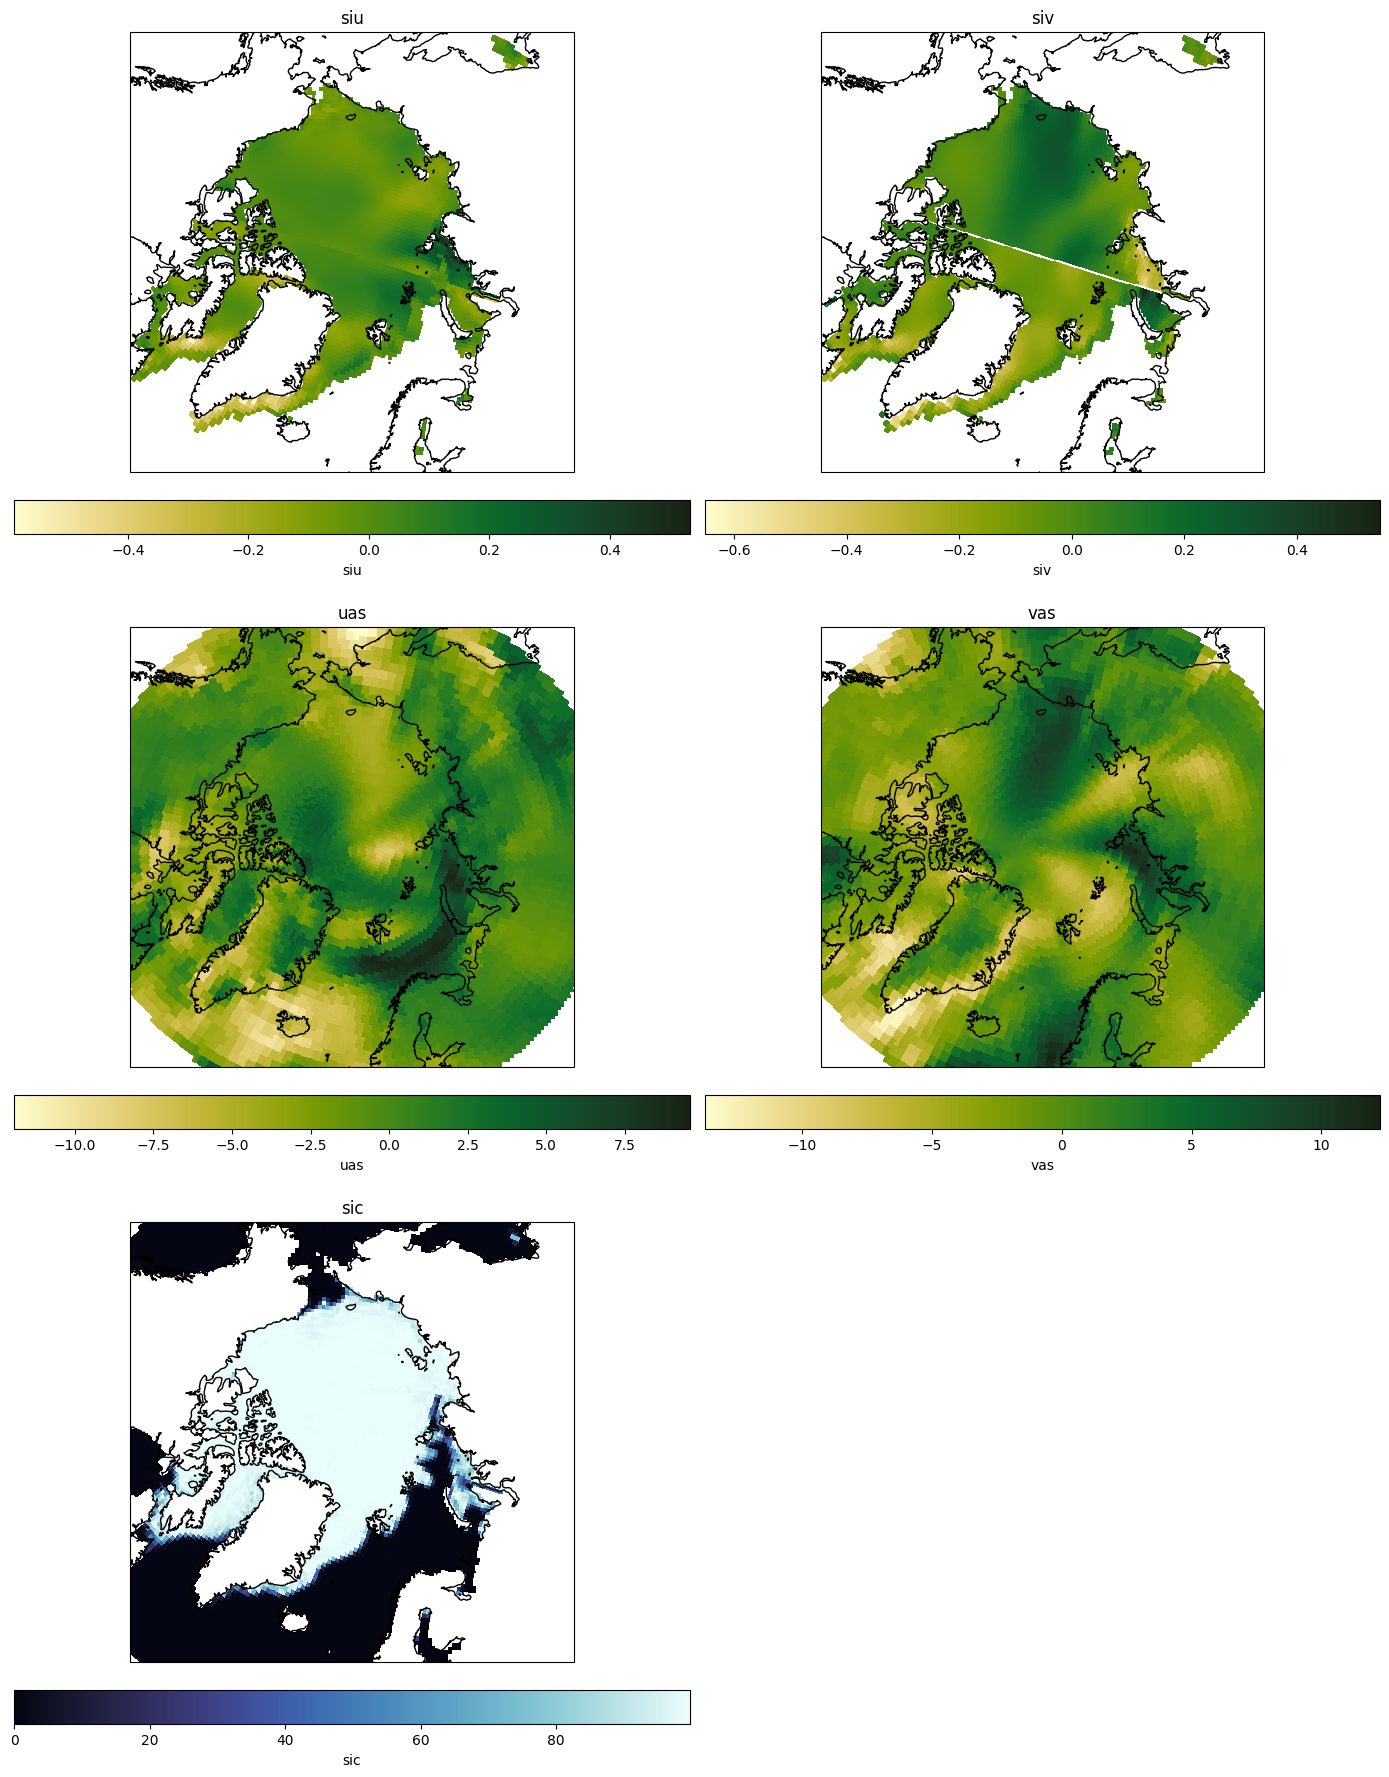

In [68]:
#maps of variables from IPSL-CM6A-LR
#wind velocity, sea-ice velocity, sea-ice concentration

fig, axs = plt.subplots(3, 2, figsize=(14, 18),
                        subplot_kw={'projection': ccrs.NorthPolarStereo()})

variables = [
    ('siu', siu[:,:,0], cmocean.cm.speed),
    ('siv', siv[:,:,0], cmocean.cm.speed),
    ('uas', uas[:,:,0], cmocean.cm.speed),
    ('vas', vas[:,:,0], cmocean.cm.speed),
    ('sic', sic[:,:,0], cmocean.cm.ice),
]

for ax, (title, data, cmap) in zip(axs.flat, variables):
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    cf = ax.pcolormesh(lon[:,:,0], lat[:,:,0], data, transform=ccrs.PlateCarree(), cmap=cmap)
    ax.coastlines()
    ax.set_title(title)
    plt.colorbar(cf, ax=ax, orientation='horizontal', pad=0.05, label=title)

# Hide the 6th subplot if only 5 plots
if len(variables) < 6:
    fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

## 3.3 Use Neural Network to Globally Reconstruct Sea-Ice Velcity



### Standardize Data

The inputs day-of-year, latitude, and longitude are standardized from [-1,1] or [0,1] using their maximum value.

Winds and sea-ice variables are standardized to zero mean, unit standard deviation.


In [69]:
var = np.concatenate((np.reshape(uas,(nx*ny*nt,1)),np.reshape(vas,(nx*ny*nt,1)),np.reshape(sic,(nx*ny*nt,1)),np.reshape(doy,(nx*ny*nt,1)),np.reshape(lat,(nx*ny*nt,1)),np.reshape(lon,(nx*ny*nt,1)),np.reshape(siu,(nx*ny*nt,1)),np.reshape(siv,(nx*ny*nt,1))),axis=1)

vari = []
for i in range(8):
    prop = var[:,i]

    miu = miu_tr[i,]
    stdev = std_tr[i,]

    if i == 3:
        var_standardized = prop/365

    elif i == 4:
        var_standardized = prop/90

    elif i == 5:
        tr_standardized = prop/180

    else:
        var_standardized = (prop-miu)/stdev

    vari.append(var_standardized)

prop = np.array(vari)

print(prop.shape)

nx = siu.shape[0]
ny = siu.shape[1]
nt = siu.shape[2]

#y is zonal and meridional sea-ice velocity
#x is zonal and meridional wind velcoity, sea-ice concentration, day-of-year, latitude, and longitude
y_map = prop[6:,:].T
x_map = prop[:6,:].T

print(x_map.shape)

(8, 1201840)
(1201840, 6)


### Make Prediction of Global Sea-Ice Velocity

In [70]:
#make prediction
y_true = y_map
y_pred = model.predict(x_map)

37558/37558 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step


### Reshape to Map

In [71]:

y_truei = y_true.reshape((nx, ny, nt, 2))
y_trueij = np.concatenate((y_truei[:,:,:,0],y_truei[:,:,:,1]),axis=2)
y_predi = y_pred.reshape((nx, ny, nt, 2))
y_predij = np.concatenate((y_predi[:,:,:,0],y_predi[:,:,:,1]),axis=2)


### Calculate Performance

In [72]:
skill = 1 - (np.sqrt(np.nanmean(np.square(y_predij - y_trueij),axis=2)))/((np.nanstd(y_trueij,axis=2)))
#corre = (np.nansum((y_trueij-np.nanmean(y_trueij,axis=2))*(y_predij-np.nanmean(y_predij,axis=2)),axis=2))/((np.sqrt(np.nansum(np.square(y_trueij-np.nanmean(y_trueij,axis=2)),axis=2)))*(np.sqrt(np.nansum(np.square(y_predij-np.nanmean(y_predij,axis=2)),axis=2))))
corren = (np.nansum((y_trueij-np.nanmean(y_trueij,axis=2, keepdims=True))*(y_predij-np.nanmean(y_predij,axis=2, keepdims=True)),axis=2, keepdims=True))
corred = ((np.sqrt(np.nansum(np.square(y_trueij-np.nanmean(y_trueij,axis=2, keepdims=True)),axis=2, keepdims=True)))*(np.sqrt(np.nansum(np.square(y_predij-np.nanmean(y_predij,axis=2, keepdims=True)),axis=2, keepdims=True))))
corre = corren/corred
print('skill:',skill.shape)
print('correlation:',corren.shape)

skill_r1 = skill
corr_r1 = corre


skill: (332, 362)
correlation: (332, 362, 1)


<ipython-input-72-576c57db52f6>:1: RuntimeWarning: Mean of empty slice
  skill = 1 - (np.sqrt(np.nanmean(np.square(y_predij - y_trueij),axis=2)))/((np.nanstd(y_trueij,axis=2)))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-72-576c57db52f6>:1: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - (np.sqrt(np.nanmean(np.square(y_predij - y_trueij),axis=2)))/((np.nanstd(y_trueij,axis=2)))
<ipython-input-72-576c57db52f6>:3: RuntimeWarning: Mean of empty slice
  corren = (np.nansum((y_trueij-np.nanmean(y_trueij,axis=2, keepdims=True))*(y_predij-np.nanmean(y_predij,axis=2, keepdims=True)),axis=2, keepdims=True))
<ipython-input-72-576c57db52f6>:4: RuntimeWarning: Mean of empty slice
  corred = ((np.sqrt(np.nansum(np.square(y_trueij-np.nanmean(y_trueij,axis=2, keepdims=True)),axis=2, keepdims=True)))*(np.sqrt(np.nansum(np.s

### Plot Performance

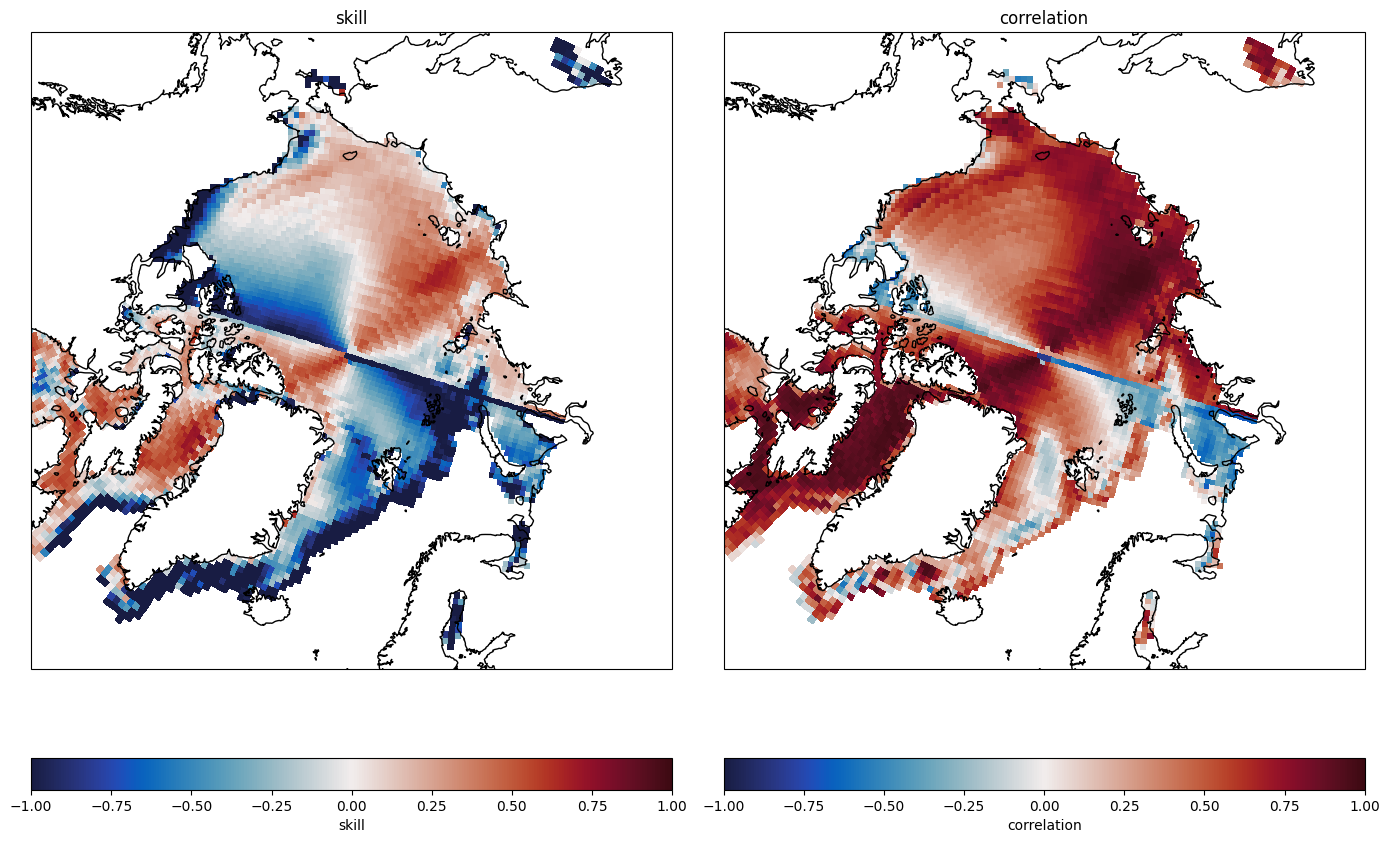

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(14, 18),
                        subplot_kw={'projection': ccrs.NorthPolarStereo()})

variables = [
    ('skill', skill, cmocean.cm.balance),
    ('correlation', corre[:,:,0], cmocean.cm.balance),
]

for ax, (title, data, cmap) in zip(axs.flat, variables):
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    cf = ax.pcolormesh(lon[:,:,0], lat[:,:,0], data, transform=ccrs.PlateCarree(), cmap=cmap,vmin=-1, vmax=1)
    ax.coastlines()
    ax.set_title(title)
    plt.colorbar(cf, ax=ax, orientation='horizontal', pad=0.05, label=title)


plt.tight_layout()
plt.show()

# 4. Scenario: What if we only had 20% of the observations?

Here we will re-train the neural network using only 20% of the synthetic observations and re-evaluate the skill of the global reconstructions.

## 4.1 Data Pre-Processing

In [74]:
#import dataset
loadpath = '/content/drive/MyDrive/Colab Notebooks/data/RECONSTRUCTION_MASK.nc'
dataset = nc.Dataset(loadpath,'r')


#variables
lat = np.array(dataset.variables['lat']) #latitude
lon = np.array(dataset.variables['lon']) #longitude
date = np.array(dataset.variables['date']) #date
sic = np.array(dataset.variables['sic_CMIP6']) #siconc
uas = np.array(dataset.variables['uas_CMIP6']) #u-wind
vas = np.array(dataset.variables['vas_CMIP6']) #v-wind
siu = np.array(dataset.variables['siu_CMIP6']) #u-ice
siv = np.array(dataset.variables['siv_CMIP6']) #v-ice

#calculate speed
icespeed = np.sqrt(np.square(siu) + np.square(siv))
windspeed = np.sqrt(np.square(uas) + np.square(vas))

#calculate day of year
ref_date = datetime(1850, 1, 1)
doy = np.array([(ref_date + timedelta(days=int(d))).timetuple().tm_yday for d in date])

print(siu.shape)

(51, 11242)


In [75]:
#subsample: only use half of the observation timesteps

ntl = lat.shape[0]
nth = int(np.round(ntl/5))

lat = lat[:nth,]
lon = lon[:nth,]
doy = doy[:nth,]
uas = uas[:,:nth]
vas = vas[:,:nth]
siu = siu[:,:nth]
siv = siv[:,:nth]
sic = sic[:,:nth]

In [76]:
#Data Splitting
#train-validate-test

emf = 26
em0 = 31
em02 = 21

sic_tr = sic[:-em0,:]
sic_va = sic[-em0:-emf,:]
sic_te = sic[-emf:-em02,:]

uas_tr = uas[:-em0,:]
uas_va = uas[-em0:-emf,:]
uas_te = uas[-emf:-em02,:]

vas_tr = vas[:-em0,:]
vas_va = vas[-em0:-emf,:]
vas_te = vas[-emf:-em02,:]

siu_tr = siu[:-em0,:]
siu_va = siu[-em0:-emf,:]
siu_te = siu[-emf:-em02,:]

siv_tr = siv[:-em0,:]
siv_va = siv[-em0:-emf,:]
siv_te = siv[-emf:-em02,:]

doy_en = np.tile(doy,(51,1))
doy_tr = doy_en[:-em0,:]
doy_va = doy_en[-em0:-emf,:]
doy_te = doy_en[-emf:-em02,:]

lat_en = np.tile(lat,(51,1))
lat_tr = lat_en[:-em0,:]
lat_va = lat_en[-em0:-emf,:]
lat_te = lat_en[-emf:-em02,:]

lon_en = np.tile(lon,(51,1))
lon_tr = lon_en[:-em0,:]
lon_va = lon_en[-em0:-emf,:]
lon_te = lon_en[-emf:-em02,:]

train = np.concatenate((uas_tr[np.newaxis,:,:],vas_tr[np.newaxis,:,:],sic_tr[np.newaxis,:,:],doy_tr[np.newaxis,:,:],lat_tr[np.newaxis,:,:],lon_tr[np.newaxis,:,:],siu_tr[np.newaxis,:,:],siv_tr[np.newaxis,:,:]),axis=0)
val = np.concatenate((uas_te[np.newaxis,:,:],vas_te[np.newaxis,:,:],sic_te[np.newaxis,:,:],doy_te[np.newaxis,:,:],lat_te[np.newaxis,:,:],lon_te[np.newaxis,:,:],siu_te[np.newaxis,:,:],siv_te[np.newaxis,:,:]),axis=0)
test = np.concatenate((uas_va[np.newaxis,:,:],vas_va[np.newaxis,:,:],sic_va[np.newaxis,:,:],doy_va[np.newaxis,:,:],lat_va[np.newaxis,:,:],lon_va[np.newaxis,:,:],siu_va[np.newaxis,:,:],siv_va[np.newaxis,:,:]),axis=0)

print(np.isnan(train).sum())
print(np.isnan(val).sum())
print(np.isnan(test).sum())

nc_tr = train.shape[1]
nt_tr = train.shape[2]

nc_te = test.shape[1]
nt_te = test.shape[2]

nc_va = val.shape[1]
nt_va = val.shape[2]


print(nc_tr)
print(nc_va)
print(nc_te)




0
0
0
20
5
5


In [77]:
#Feature Scaling

prop_train = []
prop_val = []
prop_test = []

miui = []
stdi = []

for i in range(8):
    prop_tr = train[i,:,:]
    prop_va = val[i,:,:]
    prop_te = test[i,:,:]

    miu = np.nanmean(prop_tr,axis=(0,1))
    stdev = np.nanstd(prop_tr,axis=(0,1))

    if i == 3:
        tr_standardized = prop_tr/365
        te_standardized = prop_te/365
        va_standardized = prop_va/365
    elif i == 4:
        tr_standardized = prop_tr/90
        te_standardized = prop_te/90
        va_standardized = prop_va/90
    elif i == 5:
        tr_standardized = prop_tr/180
        te_standardized = prop_te/180
        va_standardized = prop_va/180
    else:
        tr_standardized = (prop_tr-miu)/stdev
        te_standardized = (prop_te-miu)/stdev
        va_standardized = (prop_va-miu)/stdev

    prop_train.append(tr_standardized)
    prop_val.append(va_standardized)
    prop_test.append(te_standardized)

    miui.append(miu)
    stdi.append(stdev)

train_std = np.array(prop_train)
validate_std = np.array(prop_val)
test_std = np.array(prop_test)

miu_tr = np.array(miui)
std_tr = np.array(stdi)

print(miu_tr.shape)

(8,)


## 4.2 Neural Network Training

In [78]:
# Model Hyperparameters

#define NRMSE function
def norm_root_mean_squared_error(y_true,y_pred):
    return  (K.sqrt(K.mean(K.square(y_pred - y_true))))/((K.std(y_true)))

#define pearson correlation
def corr(y_true, y_pred):
    return (K.sum((y_true-K.mean(y_true))*(y_pred-K.mean(y_pred))))/((K.sqrt(K.sum(K.square(y_true-K.mean(y_true)))))*(K.sqrt(K.sum(K.square(y_pred-K.mean(y_pred))))))

# LOSS FUNCTION
LOSS = norm_root_mean_squared_error # Loss Function used
METRIC = corr # Metric for assessing model skill

# MODEL TRAINING
N_UNITS = 10 # number of nodes in layer
NUM_EPOCHS = 20 # Max number of times all of the data will be seen iteratively in training
BATCH_SIZE = 100 # Number of samples per epoch
LEARNING_RATE = .01 # Learning rate (think step size)
DROP = 0.2 # dropout rate
ACTIVATION_FUNCTION = 'relu' #activation function
OPTIMIZER = 'adam' #gradient descent algorithm
RL2 = 0.001


Epoch 1/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - corr: 0.5949 - loss: 0.7990 - val_corr: 0.7535 - val_loss: 0.6034
Epoch 2/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - corr: 0.8027 - loss: 0.6179 - val_corr: 0.8307 - val_loss: 0.5387
Epoch 3/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - corr: 0.8598 - loss: 0.5403 - val_corr: 0.8788 - val_loss: 0.4894
Epoch 4/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - corr: 0.8852 - loss: 0.5003 - val_corr: 0.8917 - val_loss: 0.4716
Epoch 5/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - corr: 0.8945 - loss: 0.4839 - val_corr: 0.8994 - val_loss: 0.4639
Epoch 6/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - corr: 0.9011 - loss: 0.4712 - val_corr: 0.9060 - val_loss: 0.4556
Epoch 7/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - corr: 0.9064 - loss: 0.4607 - val_corr: 0.9101 - val_loss: 0.4489
Epoch 8/20
2249/2249 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - corr: 0.9104 - loss: 0.4528 - val_corr: 0.9162 - val_loss: 0.4391
Epoch 9/20
2249/2249 ━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608 (2.38 KB)

 Trainable params: 202 (808.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 406 (1.59 KB)

None


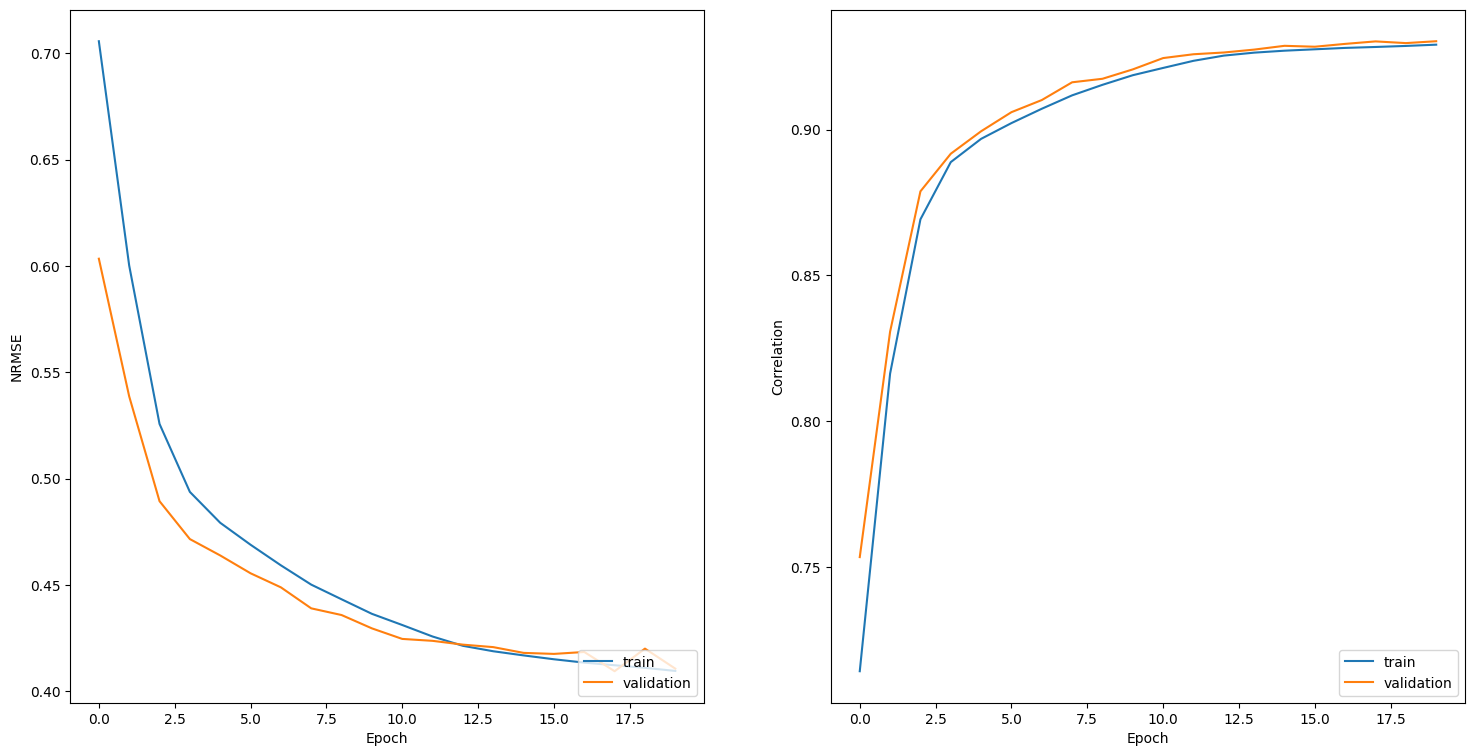

In [79]:
# Build and Complie the Model

# Example: build a fully-connected network

# In Keras a NN model is built in layers
# Most common type is sequential layers - one layer after the other with
# connections only between neighboring layers.

[nd,nch] = y_tr.shape #shape of training data

# define the model
model = tf.keras.Sequential()
model.add(layers.Dense(N_UNITS,activation=ACTIVATION_FUNCTION,kernel_regularizer=tf.keras.regularizers.l2(RL2)))
model.add(layers.Dense(N_UNITS,activation=ACTIVATION_FUNCTION,kernel_regularizer=tf.keras.regularizers.l2(RL2)))
model.add(layers.Dense(nch,activation=None))

#compile and train model
model.compile(optimizer=OPTIMIZER,loss=LOSS ,metrics=[METRIC])

# train the model
history = model.fit(x_tr,y_tr,epochs=NUM_EPOCHS,batch_size=BATCH_SIZE,shuffle=True,validation_data=(x_va,y_va))
print(history)
print(model.summary())

#evaluate model: plot the loss during training
plot1 = plt.figure(1,figsize=(18,9))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history['corr'],label='train')
plt.plot(history.history['val_corr'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('Correlation')
plt.legend(loc='lower right')
plt.show()


In [80]:
#Evaluate model predictions on testing data

# make predictions with your model using the test dataset
y_true = y_te
y_pred = model.predict(x_te)

#calculate correlation and skill
skill = 1 - (np.sqrt(np.mean(np.square(y_pred - y_true))))/((np.std(y_true)))
corre = (np.sum((y_true-np.mean(y_true))*(y_pred-np.mean(y_pred))))/((np.sqrt(np.sum(np.square(y_true-np.mean(y_true)))))*(np.sqrt(np.sum(np.square(y_pred-np.mean(y_pred))))))

print('skill:',skill)
print('correlation:',corre)


1757/1757 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
skill: 0.6265427452021051
correlation: 0.9279825183537838


## 4.3 Global Reconstructions

In [81]:
#import dataset
loadpath = '/content/drive/MyDrive/Colab Notebooks/data/RECONSTRUCTIONS_MAPS.nc'
dataset = nc.Dataset(loadpath,'r')

#variables
lat = np.array(dataset.variables['lat']) #latitude
lon = np.array(dataset.variables['lon']) #longitude
date = np.array(dataset.variables['date']) #date
sic = np.array(dataset.variables['sic_IPSL']) #siconc
uas = np.array(dataset.variables['uas_IPSL']) #u-wind
vas = np.array(dataset.variables['vas_IPSL']) #v-wind
siu = np.array(dataset.variables['siu_IPSL']) #u-ice
siv = np.array(dataset.variables['siv_IPSL']) #v-ice

nx = siu.shape[0]
ny = siu.shape[1]
nt = siu.shape[2]

#calculate speed
icespeed = np.sqrt(np.square(siu) + np.square(siv))
windspeed = np.sqrt(np.square(uas) + np.square(vas))

#calculate day of year
ref_date = datetime(1850, 1, 1)
datei = date[0,0,:]
doyi = np.array([(ref_date + timedelta(days=int(d))).timetuple().tm_yday for d in datei])
doy =  np.tile(doyi,(nx,ny,1))
print(doy.shape)


#set model fill value to NaN
#arr[arr < 1e19] = np.nan
sic[sic>1e19] = np.nan
siu[siu>1e19] = np.nan
siv[siv>1e19] = np.nan

(332, 362, 10)


<ipython-input-81-b188dc54817e>:20: RuntimeWarning: overflow encountered in square
  icespeed = np.sqrt(np.square(siu) + np.square(siv))


In [82]:
#Standardize data

var = np.concatenate((np.reshape(uas,(nx*ny*nt,1)),np.reshape(vas,(nx*ny*nt,1)),np.reshape(sic,(nx*ny*nt,1)),np.reshape(doy,(nx*ny*nt,1)),np.reshape(lat,(nx*ny*nt,1)),np.reshape(lon,(nx*ny*nt,1)),np.reshape(siu,(nx*ny*nt,1)),np.reshape(siv,(nx*ny*nt,1))),axis=1)

vari = []
for i in range(8):
    prop = var[:,i]

    miu = miu_tr[i,]
    stdev = std_tr[i,]

    if i == 3:
        var_standardized = prop/365

    elif i == 4:
        var_standardized = prop/90

    elif i == 5:
        tr_standardized = prop/180

    else:
        var_standardized = (prop-miu)/stdev

    vari.append(var_standardized)

prop = np.array(vari)

print(prop.shape)

nx = siu.shape[0]
ny = siu.shape[1]
nt = siu.shape[2]

#y is zonal and meridional sea-ice velocity
#x is zonal and meridional wind velcoity, sea-ice concentration, day-of-year, latitude, and longitude
y_map = prop[6:,:].T
x_map = prop[:6,:].T

print(x_map.shape)

(8, 1201840)
(1201840, 6)


In [83]:
#Global Reconstruction

#make prediction
y_true = y_map
y_pred = model.predict(x_map)

#reshape to map
y_truei = y_true.reshape((nx, ny, nt, 2))
y_trueij = np.concatenate((y_truei[:,:,:,0],y_truei[:,:,:,1]),axis=2)
y_predi = y_pred.reshape((nx, ny, nt, 2))
y_predij = np.concatenate((y_predi[:,:,:,0],y_predi[:,:,:,1]),axis=2)



37558/37558 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step


<ipython-input-84-7c7071a219c7>:4: RuntimeWarning: Mean of empty slice
  skill = 1 - (np.sqrt(np.nanmean(np.square(y_predij - y_trueij),axis=2)))/((np.nanstd(y_trueij,axis=2)))
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-84-7c7071a219c7>:4: RuntimeWarning: divide by zero encountered in divide
  skill = 1 - (np.sqrt(np.nanmean(np.square(y_predij - y_trueij),axis=2)))/((np.nanstd(y_trueij,axis=2)))
<ipython-input-84-7c7071a219c7>:6: RuntimeWarning: Mean of empty slice
  corren = (np.nansum((y_trueij-np.nanmean(y_trueij,axis=2, keepdims=True))*(y_predij-np.nanmean(y_predij,axis=2, keepdims=True)),axis=2, keepdims=True))
<ipython-input-84-7c7071a219c7>:7: RuntimeWarning: Mean of empty slice
  corred = ((np.sqrt(np.nansum(np.square(y_trueij-np.nanmean(y_trueij,axis=2, keepdims=True)),axis=2, keepdims=True)))*(np.sqrt(np.nansum(np.s

skill: (332, 362)
correlation: (332, 362, 1)


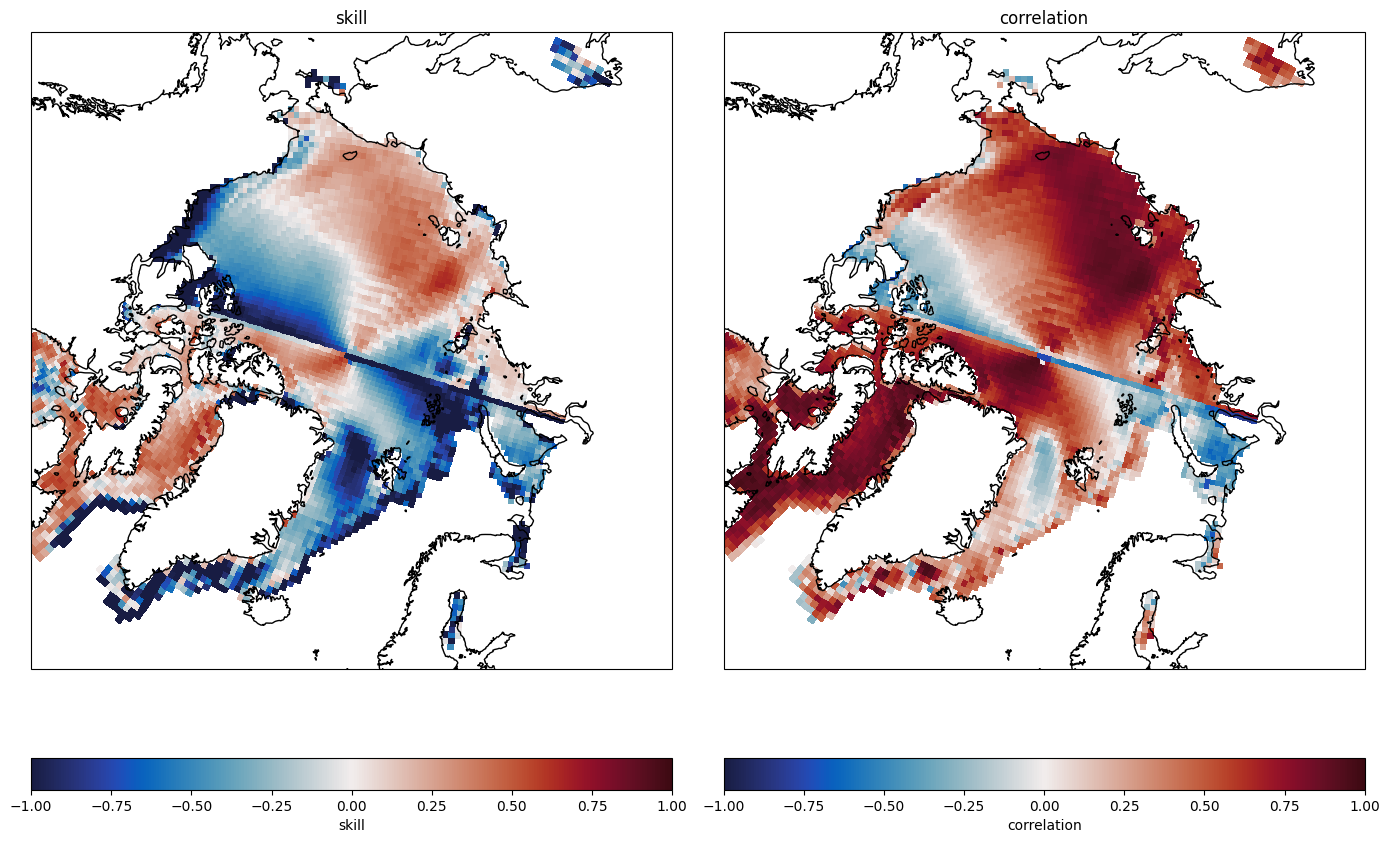

In [84]:
#Calculate and Plot Performance

#calculate performance
skill = 1 - (np.sqrt(np.nanmean(np.square(y_predij - y_trueij),axis=2)))/((np.nanstd(y_trueij,axis=2)))
#corre = (np.nansum((y_trueij-np.nanmean(y_trueij,axis=2))*(y_predij-np.nanmean(y_predij,axis=2)),axis=2))/((np.sqrt(np.nansum(np.square(y_trueij-np.nanmean(y_trueij,axis=2)),axis=2)))*(np.sqrt(np.nansum(np.square(y_predij-np.nanmean(y_predij,axis=2)),axis=2))))
corren = (np.nansum((y_trueij-np.nanmean(y_trueij,axis=2, keepdims=True))*(y_predij-np.nanmean(y_predij,axis=2, keepdims=True)),axis=2, keepdims=True))
corred = ((np.sqrt(np.nansum(np.square(y_trueij-np.nanmean(y_trueij,axis=2, keepdims=True)),axis=2, keepdims=True)))*(np.sqrt(np.nansum(np.square(y_predij-np.nanmean(y_predij,axis=2, keepdims=True)),axis=2, keepdims=True))))
corre = corren/corred
print('skill:',skill.shape)
print('correlation:',corren.shape)

#reconstruction: scenario 2
skill_r2 = skill
corr_r2 = corre


#plot performance
fig, axs = plt.subplots(1, 2, figsize=(14, 18),
                        subplot_kw={'projection': ccrs.NorthPolarStereo()})

variables = [
    ('skill', skill, cmocean.cm.balance),
    ('correlation', corre[:,:,0], cmocean.cm.balance),
]

for ax, (title, data, cmap) in zip(axs.flat, variables):
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    cf = ax.pcolormesh(lon[:,:,0], lat[:,:,0], data, transform=ccrs.PlateCarree(), cmap=cmap,vmin=-1, vmax=1)
    ax.coastlines()
    ax.set_title(title)
    plt.colorbar(cf, ax=ax, orientation='horizontal', pad=0.05, label=title)


plt.tight_layout()
plt.show()

## Plot the Difference in Performance Between the Two Reconstruction Scenarios

Scenario 1 *minus* Scenario 2

red: scenario 1 > scenario 2 (adding more data helped)

blue: scenario 2 > scenario 1 (adding more data didn't help)

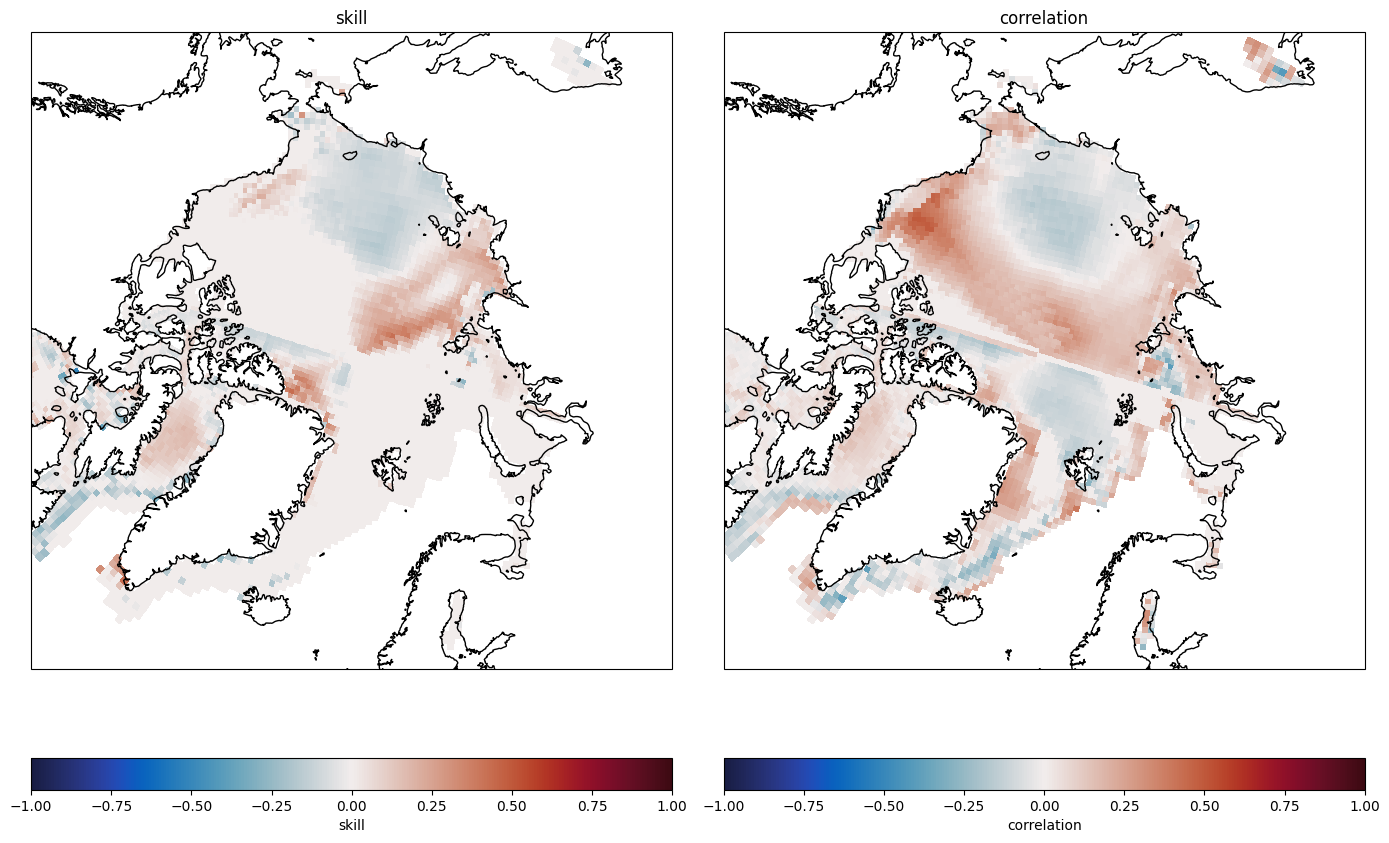

In [87]:
#difference between scenario 1 and 2
skill_r1[skill_r1 < 0] = 0
skill_r2[skill_r2 < 0] = 0
corr_r1[corr_r1 < 0] = 0
corr_r2[corr_r2 < 0] = 0
skill_delta = skill_r1-skill_r2
corr_delta = corr_r1-corr_r2

#plot performance
fig, axs = plt.subplots(1, 2, figsize=(14, 18),
                        subplot_kw={'projection': ccrs.NorthPolarStereo()})

variables = [
    ('skill', skill_delta, cmocean.cm.balance),
    ('correlation', corr_delta[:,:,0], cmocean.cm.balance),
]

for ax, (title, data, cmap) in zip(axs.flat, variables):
    ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
    cf = ax.pcolormesh(lon[:,:,0], lat[:,:,0], data, transform=ccrs.PlateCarree(), cmap=cmap,vmin=-1, vmax=1)
    ax.coastlines()
    ax.set_title(title)
    plt.colorbar(cf, ax=ax, orientation='horizontal', pad=0.05, label=title)


plt.tight_layout()
plt.show()